# N sites unitaries optimisation

Created 25/07/2024

Objectives:
* Investigate optimising over unitaries over N sites instead of 1 site unitaries over N sites

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [232]:
from functools import reduce
from operator import mul

In [119]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries
from SPTOptimization.Optimizers.OneSiteSolver import OneSiteSolver
from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment
)

# Load data

In [5]:
DATA_DIR = r"../data/transverse_cluster_200_site_dmrg"

In [6]:
f_name = DATA_DIR + r"/0_50.h5"

In [7]:
f_name

'../data/transverse_cluster_200_site_dmrg/0_50.h5'

In [8]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitons

In [10]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [15]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [19]:
test = SymmetryActionWithBoundaryUnitaries(
    test_psi,
    [np_X, np_I]*50,
    left_boundary_unitaries=[np_I,]*3,
    right_boundary_unitaries=[np_I,]*3
)

# Normalisations
What is the expectation value of all identities? What about symmetry operations on all sites?

In [14]:
test_psi.expectation_value(npc_I, [100,])

array([1.])

In [16]:
test_psi.expectation_value_multi_sites(
    [npc_I, npc_X]*100,
    0
)

array(0.00039199)

In [17]:
test_psi.expectation_value_multi_sites(
    [npc_X, npc_I]*100,
    0
)

array(-0.00081054)

In [18]:
test_psi.expectation_value_multi_sites(
    [npc_X, npc_X]*100,
    0
)

array(-4.19416384e-35)

This is not surprising. The symmetry acts on the boundaries only, and so we are effectively taking the inner product of some edge state.

# N-site unitaries
So far just applying 1-site unitaries. What if an N-site is applied? Have a simple formula for this too. Provides an upper bound.

First compute an overall tensor representing the expectation tensor with the 5 unitaries removed, combine legs to form a matrix and then apply optimisation formula.

In [26]:
left_site = test.right_symmetry_index+1
right_site = left_site + 4

In [27]:
b_matrices = [
    test_psi.get_B(i)
    for i in range(left_site, right_site+1)
]

In [28]:
len(b_matrices)

5

In [22]:
test.compute_svd_symmetry_action()

In [29]:
le = test.right_projected_symmetry_state

In [32]:
re = get_right_identity_environment(test_psi, right_site)

In [47]:
t = le

for i, b in enumerate(b_matrices):
    t = npc.tensordot(t, b, [['vR',],  ['vL',]])
    t=t.replace_label('p', 'p_{}'.format(i))
    
    t = npc.tensordot(t, b.conj(), [['vR*',],  ['vL*',]])
    t=t.replace_label('p*', 'p*_{}'.format(i))

t = npc.trace(t, leg1='vR', leg2='vR*')

In [48]:
t

<npc.Array shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2) labels=['p_0', 'p*_0', 'p_1', 'p*_1', 'p_2', 'p*_2', 'p_3', 'p*_3', 'p_4', 'p*_4']>

In [51]:
t = t.combine_legs(['p_0', 'p_1', 'p_2', 'p_3', 'p_4'])

In [52]:
t = t.combine_legs(['p*_0', 'p*_1', 'p*_2', 'p*_3', 'p*_4'])

In [53]:
t

<npc.Array shape=(32, 32) labels=['(p_0.p_1.p_2.p_3.p_4)', '(p*_0.p*_1.p*_2.p*_3.p*_4)']>

In [54]:
np_t = t.to_ndarray()

In [55]:
np_t.shape

(32, 32)

In [59]:
U, S, Vh = np.linalg.svd(np_t)

In [60]:
np.sum(S)

1.407161495509056

Optimal value is likely $\sqrt{2}$, so this is pretty good.

In [58]:
S

array([3.66102898e-01, 3.66102715e-01, 3.37046191e-01, 3.37046049e-01,
       1.84616503e-04, 1.84616503e-04, 1.69963946e-04, 1.69963937e-04,
       4.01957344e-05, 4.01957328e-05, 3.70054963e-05, 3.70054963e-05,
       2.02697092e-08, 2.02697001e-08, 1.86609520e-08, 1.86609433e-08,
       5.01385787e-11, 4.11921867e-11, 3.93129094e-11, 3.22981684e-11,
       8.18054440e-13, 6.72083087e-13, 6.41424601e-13, 5.26960910e-13,
       7.57349085e-15, 6.22237154e-15, 5.94277894e-15, 4.88497056e-15,
       1.24530738e-16, 1.03453386e-16, 1.01715722e-16, 7.67935640e-17])

In [61]:
W = np.dot(U, Vh)

In [67]:
U, S, Vh = npc.svd(t, inner_labels = ['i', 'i*'])

In [68]:
S

array([3.66102898e-01, 3.66102715e-01, 3.37046191e-01, 3.37046049e-01,
       1.84616503e-04, 1.84616503e-04, 1.69963946e-04, 1.69963937e-04,
       4.01957344e-05, 4.01957328e-05, 3.70054963e-05, 3.70054963e-05,
       2.02697092e-08, 2.02697001e-08, 1.86609520e-08, 1.86609433e-08,
       5.01385787e-11, 4.11921867e-11, 3.93129094e-11, 3.22981684e-11,
       8.18054436e-13, 6.72083087e-13, 6.41424596e-13, 5.26960915e-13,
       7.57362106e-15, 6.22238172e-15, 5.94295312e-15, 4.88498156e-15,
       1.20288955e-16, 1.09931819e-16, 1.02383345e-16, 9.14640212e-17])

In [69]:
U

<npc.Array shape=(32, 32) labels=['(p_0.p_1.p_2.p_3.p_4)', 'i']>

In [70]:
Vh

<npc.Array shape=(32, 32) labels=['i*', '(p*_0.p*_1.p*_2.p*_3.p*_4)']>

Now construct the optimal N site unitary, and attempt to decompose into a tensor product of unitaries via SVD.

Few different ways to "cut" the sites, let's try them all.

In [71]:
W = npc.tensordot(U, Vh, [['i',], ['i*',]])

In [72]:
W

<npc.Array shape=(32, 32) labels=['(p_0.p_1.p_2.p_3.p_4)', '(p*_0.p*_1.p*_2.p*_3.p*_4)']>

In [74]:
W = W.split_legs()

In [75]:
W

<npc.Array shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2) labels=['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'p*_0', 'p*_1', 'p*_2', 'p*_3', 'p*_4']>

In [76]:
W_0 = W.combine_legs(['p_0', 'p*_0'])
W_0 = W_0.combine_legs(
    ['p_1', 'p*_1', 'p_2', 'p*_2', 'p_3', 'p*_3', 'p_4', 'p*_4',]
)
)

In [77]:
W_0

<npc.Array shape=(4, 256) labels=['(p_0.p*_0)', '(p_1.p*_1.p_2.p*_2.p_3.p*_3.p_4.p*_4)']>

In [78]:
U_0, S_0, Vh_0 = npc.svd(W_0, inner_labels = ['i', 'i*'])

In [79]:
S_0

array([5.30201863, 1.89392005, 0.47319313, 0.27884318])

In [127]:
np_U_0 = U_0.split_legs().to_ndarray()[...,0]

Check that the result is in fact unitary. (Close enough)

In [129]:
np_U_0 @ (np_U_0.conj().T)

array([[5.00000000e-01+0.j, 1.43765208e-16+0.j],
       [1.43765208e-16+0.j, 5.00000000e-01+0.j]])

In [80]:
W_1 = W.combine_legs(['p_0', 'p*_0', 'p_1', 'p*_1'])
W_1 = W_1.combine_legs(
    ['p_2', 'p*_2', 'p_3', 'p*_3', 'p_4', 'p*_4']
)

In [81]:
W_1

<npc.Array shape=(16, 64) labels=['(p_0.p*_0.p_1.p*_1)', '(p_2.p*_2.p_3.p*_3.p_4.p*_4)']>

In [84]:
U_1, S_1, Vh_1 = npc.svd(W_1, inner_labels = ['i', 'i*'])

In [85]:
S_1

array([3.73476145, 3.65420292, 1.40925851, 1.26044198, 0.89076655,
       0.34055237, 0.30255463, 0.19504619, 0.16914154, 0.15123592,
       0.08956417, 0.08729223, 0.07767774, 0.07553646, 0.05831385,
       0.04845751])

In [86]:
W_2 = W.combine_legs(['p_0', 'p*_0', 'p_1', 'p*_1', 'p_2', 'p*_2'])
W_2 = W_2.combine_legs(
    ['p_3', 'p*_3', 'p_4', 'p*_4']
)

In [87]:
W_2

<npc.Array shape=(64, 16) labels=['(p_0.p*_0.p_1.p*_1.p_2.p*_2)', '(p_3.p*_3.p_4.p*_4)']>

In [88]:
U_2, S_2, Vh_2 = npc.svd(W_2, inner_labels = ['i', 'i*'])

In [89]:
S_2

array([3.16177792, 3.06684575, 2.46107764, 2.20092214, 0.82280272,
       0.73609489, 0.46290582, 0.41336233, 0.1875453 , 0.14332147,
       0.12885699, 0.09881673, 0.06078629, 0.05255569, 0.0471475 ,
       0.04362077])

In [90]:
W_3= W.combine_legs(['p_0', 'p*_0', 'p_1', 'p*_1', 'p_2', 'p*_2', 'p_3', 'p*_3'])
W_3 = W_3.combine_legs(
    ['p_4', 'p*_4']
)

In [91]:
W_3

<npc.Array shape=(256, 4) labels=['(p_0.p*_0.p_1.p*_1.p_2.p*_2.p_3.p*_3)', '(p_4.p*_4)']>

In [92]:
U_3, S_3, Vh_3 = npc.svd(W_3, inner_labels = ['i', 'i*'])

In [93]:
S_3

array([4.40984182, 3.30651071, 1.10756247, 0.62736547])

Automate above, check resulting right expectation for different values of N:

In [116]:
def compute_right_scores(n):
    left_site = test.right_symmetry_index+1
    right_site = test.right_symmetry_index + n
    le = test.right_projected_symmetry_state
    
    t = le

    b_matrices = [
        test_psi.get_B(i)
        for i in range(left_site, right_site+1)
    ]

    out = np.zeros(n)
    top_legs = list()
    bottom_legs = list()

    for i, b in enumerate(b_matrices):
        new_top_leg = 'p_{}'.format(i)
        top_legs.append(new_top_leg)

        t = npc.tensordot(t, b, [['vR',],  ['vL',]])        
        t=t.replace_label('p', new_top_leg)

        
        new_bottom_leg = 'p*_{}'.format(i)
        bottom_legs.append(new_bottom_leg)

        t = npc.tensordot(t, b.conj(), [['vR*',],  ['vL*',]])
        t=t.replace_label('p*', new_bottom_leg)

        t0 = t.combine_legs(top_legs).combine_legs(bottom_legs)
        t0 = npc.trace(t0, leg1='vR', leg2='vR*')
        S = npc.svd(t0, inner_labels = ['i', 'i*'], compute_uv=False)
        out[i] = np.sum(S)

    return out

In [117]:
right_scores = compute_right_scores(10)

In [118]:
right_scores

array([8.13733648e-08, 1.36514717e+00, 1.36514717e+00, 1.40716150e+00,
       1.40716150e+00, 1.41363008e+00, 1.41363008e+00, 1.41482896e+00,
       1.41482896e+00, 1.41506554e+00])

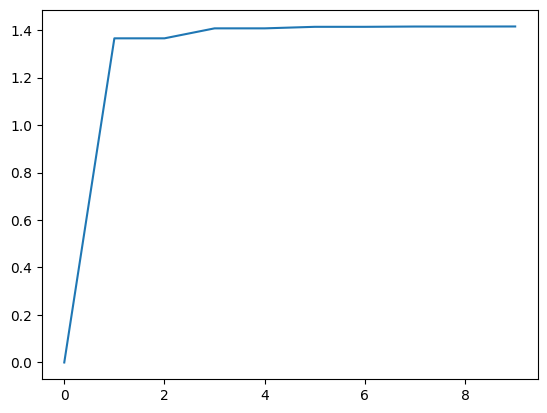

In [120]:
plt.plot(right_scores)

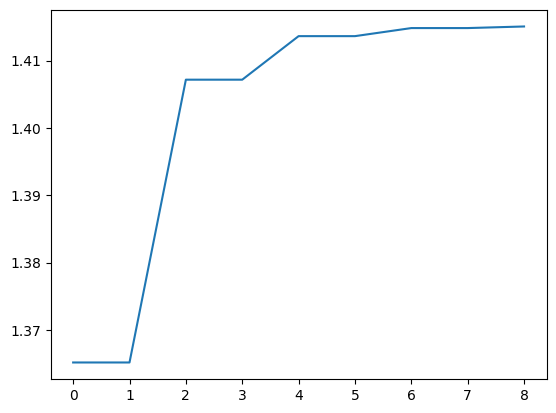

In [121]:
plt.plot(right_scores[1:])

Interesting "plateaus"... The right expectation only increases when n goes from odd to even. Due to the 2 site nature of the original symmetries...?

Decompose into n site unitary into tensor product of 1 site unitaries.

In [159]:
def one_site_tensorize_unitary(t, n, i):
    left_leg_labels = [f'p_{i}', f'p*_{i}']
    right_leg_labels = [
        *[f'p_{j}' for j in range(i+1, n)],
        *[f'p*_{j}' for j in range(i+1, n)],
    ]

    t_split = (
        t
        .combine_legs(left_leg_labels)
        .combine_legs(right_leg_labels)
    )

    U, S, Vh = npc.svd(t_split, inner_labels = ['i', 'i*'])

    U0 = U[:,0].split_legs()
    V0 = Vh[0,:].split_legs()

    return (U0, S, V0)

In [135]:
t = t.split_legs()

In [136]:
t

<npc.Array shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2) labels=['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'p*_0', 'p*_1', 'p*_2', 'p*_3', 'p*_4']>

In [204]:
def tensorize_unitary(t, n):
    upper_leg_labels = [f'p_{j}' for j in range(n)]
    lower_leg_labels = [f'p*_{j}' for j in range(n)]

    t_combined = (
        t
        .combine_legs(upper_leg_labels)
        .combine_legs(lower_leg_labels)
    )

    U, S, Vh = npc.svd(t_combined.complex_conj(), inner_labels=['i', 'i*'])
    W = npc.tensordot(U, Vh, ['i', 'i*']).split_legs()

    unitaries = list()
    schmidt_values = list()

    for i in range(n-1):
        ul, sv, W = one_site_tensorize_unitary(W, n, i)
        ul = ul.replace_labels([f'p_{i}', f'p*_{i}'], ['p', 'p*'])
        unitaries.append(ul)
        schmidt_values.append(sv)

    W = W.replace_labels([f'p_{n-1}', f'p*_{n-1}'], ['p', 'p*'])
    unitaries.append(W)

    return (unitaries, schmidt_values)

In [205]:
unitaries, schmidt_values = tensorize_unitary(t, 5)

In [206]:
unitaries

[<npc.Array shape=(2, 2) labels=['p', 'p*']>,
 <npc.Array shape=(2, 2) labels=['p', 'p*']>,
 <npc.Array shape=(2, 2) labels=['p', 'p*']>,
 <npc.Array shape=(2, 2) labels=['p', 'p*']>,
 <npc.Array shape=(2, 2) labels=['p', 'p*']>]

In [207]:
schmidt_values

[array([5.30201863, 1.89392005, 0.47319313, 0.27884318]),
 array([0.70440088, 0.68913462, 0.1676845 , 0.02819209]),
 array([0.82291136, 0.53338709, 0.16280378, 0.10867401]),
 array([9.99985210e-01, 5.38699866e-03, 6.75999864e-04, 3.22411508e-04])]

In [233]:
schmidt_factor = reduce(mul, (l[0] for l in schmidt_values))

In [234]:
schmidt_factor

3.073319920981477

Check unitaries are actually unitaries:

In [236]:
u = unitaries[0].to_ndarray()

In [237]:
u @ (u.conj().T)

array([[5.00000000e-01+0.j, 1.39753009e-18+0.j],
       [1.39753009e-18+0.j, 5.00000000e-01+0.j]])

In [238]:
for u in unitaries:
    np_U = u.to_ndarray()
    print(np_U @ (np_U.conj().T))

[[5.00000000e-01+0.j 1.39753009e-18+0.j]
 [1.39753009e-18+0.j 5.00000000e-01+0.j]]
[[0.50453465+0.j 0.03475558+0.j]
 [0.03475558+0.j 0.49546535+0.j]]
[[ 0.4996206+0.j -0.0006554+0.j]
 [-0.0006554+0.j  0.5003794+0.j]]
[[ 0.88052068+0.j -0.04095727+0.j]
 [-0.04095727+0.j  0.11947932+0.j]]
[[0.48914819+0.j 0.00119075+0.j]
 [0.00119075+0.j 0.51085181+0.j]]


Not unitary, but not far off either.

In [208]:
t

<npc.Array shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2) labels=['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'p*_0', 'p*_1', 'p*_2', 'p*_3', 'p*_4']>

In [223]:
c = t

In [224]:
for i, u in enumerate(unitaries):
    upper_label = f'p_{i}'
    lower_label = f'p*_{i}'

    label_pair = [lower_label, upper_label]
    c = npc.tensordot(c, u, [label_pair, ['p', 'p*']])

In [225]:
c

(0.2193071074771448+0j)

Not good. Should check with class.

In [231]:
np_unitaries = [u.to_ndarray() for u in unitaries]

In [227]:
opt_test = SymmetryActionWithBoundaryUnitaries(
    test_psi,
    [np_X, np_I]*50,
    left_boundary_unitaries=[np_I,]*3,
    right_boundary_unitaries=np_unitaries
)

In [228]:
opt_test.compute_svd_symmetry_action()

In [229]:
opt_test.compute_svd_approximate_expectation()

(-3.840662407864379e-12+0j)

In [230]:
opt_test.right_expectation

(0.21930710747714474+0j)

Note that the "unitaries" are often close to unitaries but off by a fixed scalar. If this were the case for all of them, then could find a correction term to get a sensible answer.

# Conclusion
 * N site unitary optimisation provides a useful bound on the highest possible expectation one can... expect.
 * May struggle with scaling as on n sites one must find the singular values of a $2^n$ dimensional square matrix.
 * Could potentially provide a solution for the 1 site case provided we have a way to decompose the unitary. Not obvious to me how to do this. First need to decompose, but then need to ensure that the factors are still unitaries.